In [833]:
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import os
from parameters import parameters as pm
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

import joblib

import warnings
warnings.filterwarnings('ignore')

In [834]:
df=pd.read_excel('samples_para_stress.xlsx')

In [835]:
df.columns

Index(['a', 'b', 'af', 'bf', 'as', 'bs', 'afs', 'bfs', 'gamma', 'sig_fs_fs',
       'sig_sf_fs', 'sig_fn_fn', 'sig_nf_fn', 'sig_ns_sn', 'sig_sn_sn'],
      dtype='object')

In [836]:
df.columns=['a','b','af','bf','as','bs','afs','bfs','gamma','sigma_fs_fs','sigma_sf_fs','sigma_fn_fn','sigma_nf_fn','sigma_ns_sn','sigma_sn_sn']

In [837]:
df.describe()

,a,b,af,bf,as,bs,afs,bfs,gamma,sigma_fs_fs,sigma_sf_fs,sigma_fn_fn,sigma_nf_fn,sigma_ns_sn,sigma_sn_sn
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,5.024920,10.049809,5.050226,10.050113,5.024950,10.050327,5.025006,10.050025,0.250499,19.915902,19.888670,9.389622,8.930255,8.930255,9.362391
std,2.873615,5.747514,2.859263,5.747675,2.873896,5.747392,2.873816,5.747483,0.144125,48.957982,48.874682,28.828325,28.541264,28.541264,28.803997
min,0.058259,0.104464,0.106463,0.107094,0.057091,0.114253,0.054299,0.105439,0.001382,0.009766,0.009766,0.001326,0.001325,0.001325,0.001326
25%,2.543715,5.080369,2.574294,5.077551,2.542163,5.077442,2.539214,5.072416,0.125972,1.275153,1.290297,0.534220,0.476976,0.476976,0.554983
50%,5.028504,10.049171,5.051190,10.050950,5.027898,10.056454,5.023737,10.054864,0.250336,4.158782,4.238374,1.999330,1.657150,1.657150,1.955840
75%,7.506693,15.012347,7.524144,15.017921,7.512170,15.022177,7.511243,15.028958,0.375067,15.068588,14.957548,6.393430,5.688406,5.688406,6.364693
max,9.999542,19.989205,9.996317,19.985924,9.991035,19.988710,9.996559,19.996390,0.499751,547.477996,544.933094,426.912905,422.845102,422.845102,425.015898


In [838]:
df.head(5)

,a,b,af,bf,as,bs,afs,bfs,gamma,sigma_fs_fs,sigma_sf_fs,sigma_fn_fn,sigma_nf_fn,sigma_ns_sn,sigma_sn_sn
0,2.269794,2.666562,4.846185,8.074885,9.050195,1.699229,7.574872,7.165843,0.126117,1.388801,1.405643,0.318145,0.298663,0.298663,0.334987
1,2.508497,5.591436,1.046348,16.572831,2.024843,16.429041,6.570892,3.324727,0.174722,1.801934,1.812532,0.531205,0.519869,0.519869,0.541803
2,1.939195,16.922009,1.028001,3.286520,9.715426,15.650890,6.993064,6.357941,0.101290,0.991868,1.009956,0.235798,0.233661,0.233661,0.253886
3,7.967943,2.571042,8.998735,7.559782,2.191194,4.473826,3.193243,17.432812,0.266110,5.816317,5.548518,2.896023,2.543768,2.543768,2.628225
4,5.475308,16.789631,6.349736,7.223862,0.397983,8.038741,4.969531,16.032985,0.365182,34.862726,34.204198,19.466924,18.763675,18.763675,18.808396


In [839]:
feature_columns=['sigma_fs_fs','sigma_sf_fs','sigma_fn_fn','sigma_nf_fn','sigma_ns_sn','sigma_sn_sn']
for col in feature_columns:
    df[col]=(df[col]-df[col].mean())/df[col].std()

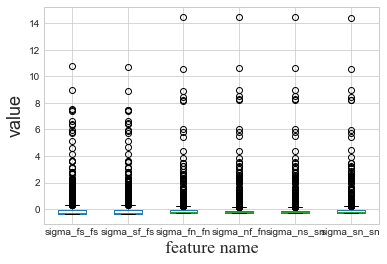

In [840]:
df[feature_columns].boxplot()
plt.gca().set_ylabel("value",fontdict={"size":18})
plt.gca().set_xlabel("feature name",fontdict={'family' : 'Times New Roman', 'size' : 18})
plt.show()

In [841]:
def box_plot_outliers(data_ser, box_scale):
    """
    remove some outliers
    :param data_ser: pandas.Series
    :param box_scale: the scale，
    :return:
    """
    iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
    val_low = data_ser.quantile(0.25) - iqr
    val_up = data_ser.quantile(0.75) + 1.5*iqr
    low_index = data_ser[data_ser < val_low].index
    up_index = data_ser[data_ser > val_up].index

    return list(low_index) + list(up_index)
  

In [842]:
error_index = []
for col in feature_columns:
    error_index += box_plot_outliers(df[col],box_scale=-0.0019)
df=df.drop(error_index)

In [843]:
print(len(error_index))
data_ser = df[feature_columns[0]]
box_scale = -0.0019
iqr =(data_ser.quantile(0.75) - data_ser.quantile(0.25))
val_up = data_ser.quantile(0.75) + 1.5*iqr

print(val_up)


3030
-0.15462228843010242


In [844]:
q_data,y_data=df.iloc[:,0:9],df.iloc[:,9:10]


###################################
print(q_data,y_data)

            a          b        af         bf        as         bs       afs  \
3    7.967943   2.571042  8.998735   7.559782  2.191194   4.473826  3.193243   
5    2.615082  12.229693  6.530510  13.339543  5.737378   9.032523  4.345270   
7    5.610860   3.838120  8.871015  11.359349  6.959370   4.329714  8.433060   
14   8.927330   1.284883  6.769933  18.618157  0.361250   1.236720  1.750455   
16   3.125155   7.316812  5.597908   7.646939  1.542620   1.188806  3.757215   
..        ...        ...       ...        ...       ...        ...       ...   
990  1.511934   3.014015  0.165817  11.171851  0.954214  11.214662  7.100382   
992  7.104071   4.734259  5.920262  12.151459  5.462483   1.834432  5.348474   
993  2.365985  13.605445  4.144001   8.623786  1.707202   1.540658  7.981380   
995  7.165104   9.005023  5.855529  10.834621  6.435474   2.434221  4.634764   
996  7.814740   2.461724  0.692261  15.672442  2.751700  10.077316  8.780820   

           bfs     gamma  
3    17.4328

In [845]:
train_size=int(0.9*len(q_data))

In [846]:
q_data_train,q_data_test=q_data.iloc[:train_size,:],q_data.iloc[train_size:,:]
y_data_train,y_data_test=y_data.iloc[:train_size,:],y_data.iloc[train_size:,:]

In [847]:
q_data_exp,y_data_exp=q_data.iloc[-1,:].values.reshape((1,-1)),y_data.iloc[-1,:].values.reshape((1,-1))
print(y_data_exp)

[[-0.30046787]]


In [848]:
q_data_train.shape,q_data_test.shape,q_data_exp.shape,y_data_exp.shape

((331, 9), (37, 9), (1, 9), (1, 1))

In [849]:
q_data_exp

array([[ 7.81473977,  2.4617237 ,  0.69226091, 15.67244204,  2.75169997,
        10.07731607,  8.78082013, 19.64428786,  0.19335427]])

In [850]:
class SklearnHelper(object):
    def __init__(self, clf, params=None,isMuilt_reg=False):
        if isMuilt_reg: self.clf= MultiOutputRegressor (clf(**params))
        else: self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def score(self,x,y):
        return self.clf.score(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [851]:
def mse_loss(y_true,y_pred):
    return np.mean(np.square(y_true-y_pred))

X = q_data_train.values
y = y_data_train.values
X_test = q_data_test.values
y_test=y_data_test.values

In [852]:
X.shape,y.shape,X_test.shape,y_test.shape

((331, 9), (331, 1), (37, 9), (37, 1))

In [853]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

In [854]:
## not yet finished
kernel = RBF(length_scale= 10, length_scale_bounds=(0.0,25))
# kernel = RBF(**gpr_para[feat_flag])

gpr_models=[]
for feat_flag in range(1):
    gpr_sub = GaussianProcessRegressor(kernel=kernel,
                    random_state=0)
    print('fitting feature %d' % feat_flag)
    gpr_sub.fit(X, y[:, feat_flag])
    print(gpr_sub.kernel_)
    gpr_models.append(gpr_sub)

fitting feature 0
RBF(length_scale=16.2)


In [855]:
# predicting the output and others using the selected hyperparameters
for feat_flag in range(1):
    print('fitting feature %d' % feat_flag)
    gpr_sub = gpr_models[feat_flag]
    pred = gpr_sub.predict(X_test)
    print('gpr Test: mse loss={:.6f} r2_score={:.6f}'.format(
        mse_loss(y_test[:, feat_flag], pred),metrics.r2_score(y_test[:, feat_flag], pred)))

fitting feature 0
gpr Test: mse loss=0.002212 r2_score=0.515298


In [856]:
y_pred=np.zeros(y_test.shape)
for ix, model in enumerate(gpr_models):
    y_pred[:, ix] += model.predict(X_test)

for feat_flag in range(1):
    loss_test = mse_loss(y_test[:, feat_flag], y_pred[:, feat_flag])
    R2_test  = metrics.r2_score(y_test[:, feat_flag], y_pred[:, feat_flag])
    print('Test: mse loss={:.6f} r2_score={:.6f}'.format(loss_test, R2_test))

Test: mse loss=0.002212 r2_score=0.515298


Text(0.5, 1.0, 'feature 1')

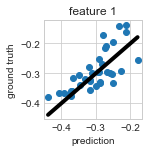

In [857]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.subplot(2,3,1)
feat_flag = 0;
feature_min = min(y_pred[:,feat_flag])
feature_max = max(y_pred[:,feat_flag])
feature_linspace = np.linspace(feature_min, feature_max, 100)
plt.plot(feature_linspace, feature_linspace, '-k', linewidth=4)
plt.scatter(y_pred[:,feat_flag], y_test[:,feat_flag], marker='o');
plt.xlabel('prediction')
plt.ylabel('ground truth');
plt.title('feature 1')
#plt.show()

